In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pydicom
from tqdm import tqdm
import nibabel as nib
from glob import glob

In [2]:
# Load data
train_df = pd.read_csv("../Data/train.csv")

Text(0.5, 1.0, 'Fractures by patient')

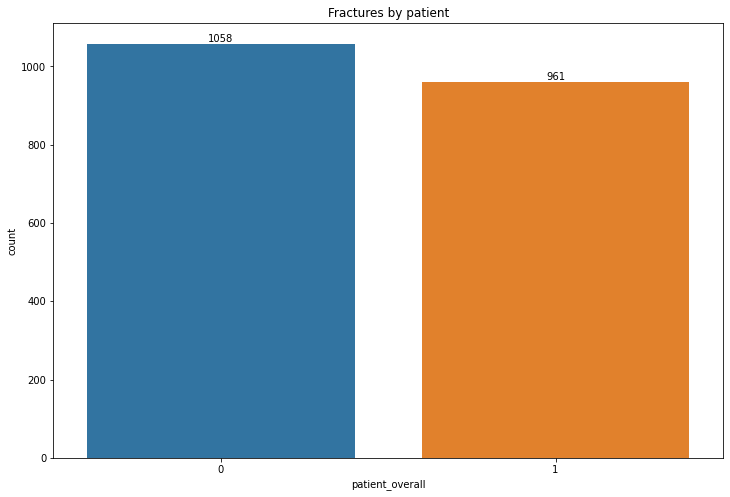

In [3]:
plt.figure(figsize=(12,8))
ax = sns.countplot(data=train_df, x='patient_overall')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Fractures by patient')

Text(0.5, 1.0, 'Fractures by vertebrae')

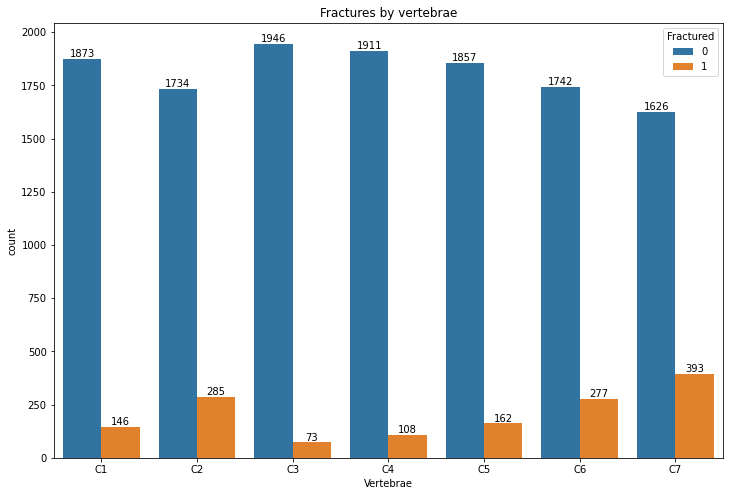

In [4]:
plt.figure(figsize=(12,8))
train_verb = pd.melt(train_df, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vertebrae",
             value_name="Fractured")

ax = sns.countplot(data=train_verb, x='Vertebrae', hue='Fractured')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Fractures by vertebrae')

Text(0.5, 0, 'Number of fractures')

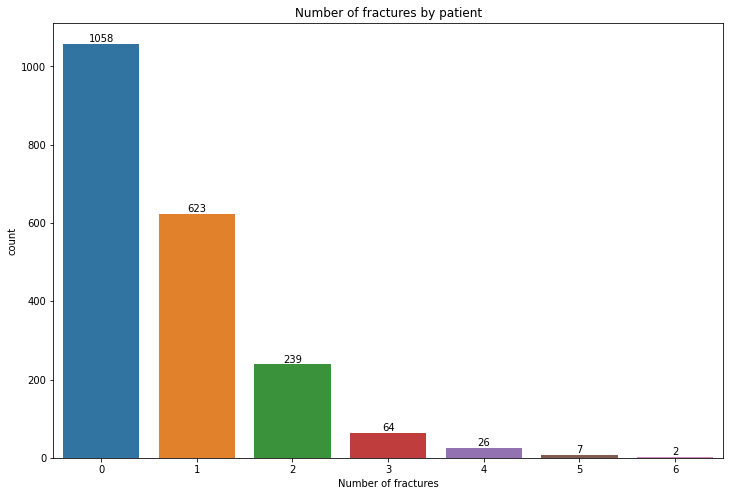

In [5]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x = train_df[['C1','C2','C3','C4','C5','C6','C7']].sum(axis=1))
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of fractures by patient')
plt.xlabel('Number of fractures')

Text(0.5, 1.0, 'Correlations')

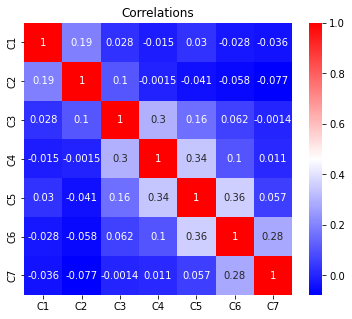

In [6]:
# Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(train_df[['C1','C2','C3','C4','C5','C6','C7']].corr(), cmap='bwr',annot=True)
plt.title('Correlations')

# Dicom Data Processing

In [7]:
dcm = pydicom.dcmread("../Data/train_images/1.2.826.0.1.3680043.12281/110.dcm")
dcm

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.12281.1.110
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.12281.1.110
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '181303.847051'
(0010, 0010) Patient's Name                      PN: '12281'
(0010, 0020) Patient ID                          LO: '12281'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826

In [8]:
# Load the scans in given folder path
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2])) # Sort the images based on the Z axis.
    return slices

In [9]:
path="../Data/train_images/1.2.826.0.1.3680043.14"
patient=load_scan(path)

(-0.5, 511.5, 511.5, -0.5)

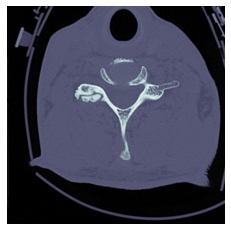

In [10]:
#Ploting pixel array
plt.imshow(patient[110].pixel_array,cmap='bone')
plt.axis("off")

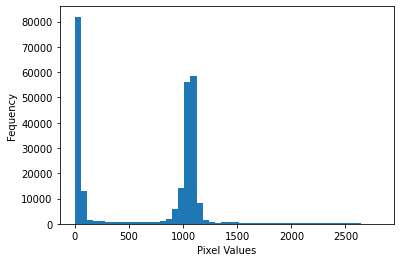

In [11]:
#Ploting pixel array distribution
plt.hist(patient[110].pixel_array.flatten(),bins=50)
plt.xlabel("Pixel Values")
plt.ylabel("Fequency")
plt.show()

# .nii files in Segmentation folder

In [12]:
def load_NIfTI(path):
    nii_example = nib.load(path)

    # Convert to numpy array
    seg = nii_example.get_fdata()
    print(seg.shape)
    
    return seg

In [13]:
path="../Data/segmentations/1.2.826.0.1.3680043.12281.nii"
segment_image=load_NIfTI(path)

(512, 512, 331)


In [14]:
# Align orientation with dicom images i.e. sagital to axial
segment_image = segment_image[:, ::-1, ::-1].transpose(2, 1, 0)
segment_image.shape

(331, 512, 512)

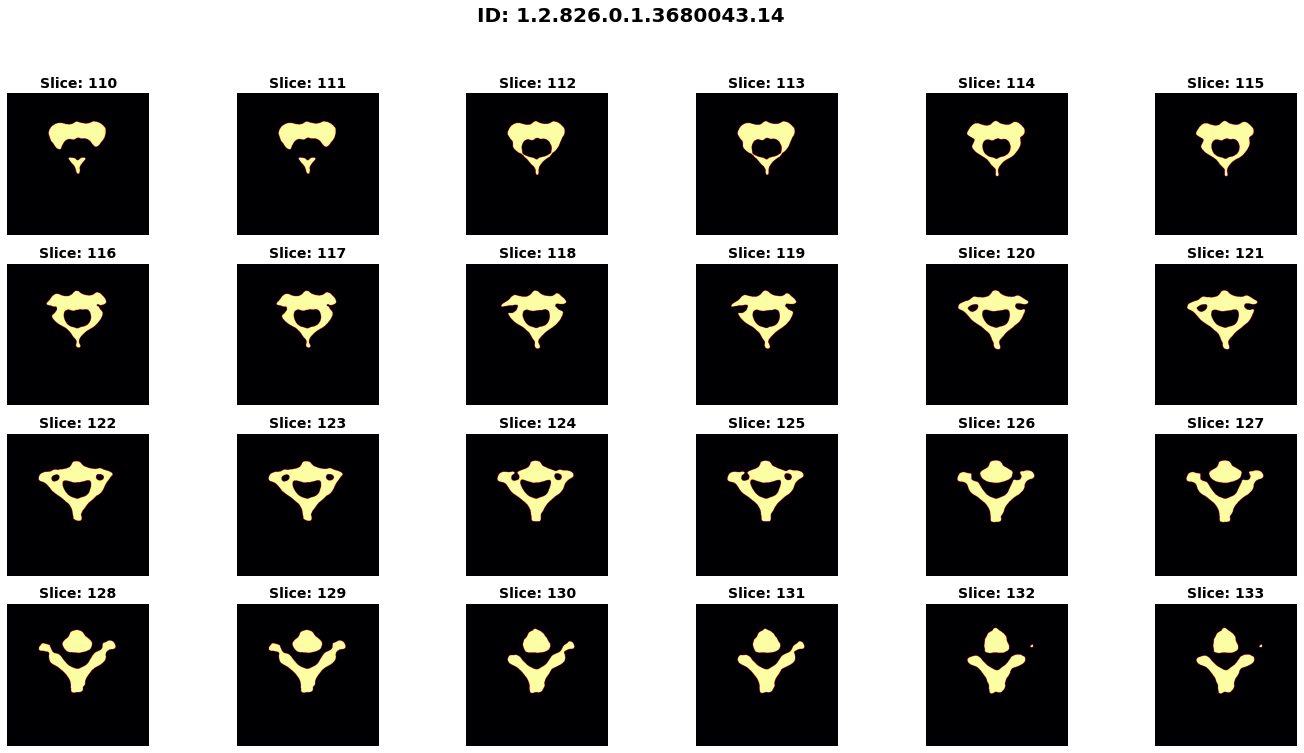

In [15]:
# Plot images
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(24,12))
fig.suptitle(f'ID: 1.2.826.0.1.3680043.14', weight="bold", size=20)

for i in range(110,134):
    img = segment_image[i]

    # Plot the image
    x = (i-110) // 6
    y = (i-110) % 6

    axes[x, y].imshow(img, cmap='inferno')
    axes[x, y].set_title(f"Slice: {i}", fontsize=14, weight='bold')
    axes[x, y].axis('off')

In [16]:
np.unique(segment_image[110])

array([0., 2.])

# Creating CSV of Metadata from DICOM files of Train Images

In [17]:
def get_observations(path):
    data = pydicom.read_file(path)
    
    observations = {
        "Rows" : data.get("Rows"),
        "Columns" : data.get("Columns"),
        "SOPInstanceUID" : data.get("SOPInstanceUID"),
        "SliceThickness" : data.get("SliceThickness"),
        "InstanceNumber" : data.get("InstanceNumber"),
        "ImagePositionPatient" : data.get("ImagePositionPatient"),
        "ImageOrientationPatient" : data.get("ImageOrientationPatient"),
    }

    # String columns
    str_columns = ["SOPInstanceUID", "InstanceNumber", "SliceThickness"]
    for k in str_columns:
        observations[k] = str(data.get(k)) if k in data else None

    
    return observations

def get_metadata(example):
    dicts = []

    for k in tqdm(range(len(train_df))):
        dt = train_df.iloc[k, :]

        if dt.patient_overall == 1:
            # Get all .dcm paths for this Instance
            dcm_paths = glob(f"../Data/trains_images/{dt.StudyInstanceUID}/*")

            for path in dcm_paths:
                datas= get_observations(path)
                dicts.append(datas)
                    

    meta_train_data = pd.DataFrame(data=dicts, columns=example.keys())
    meta_train_data.to_csv("meta_segmentation.csv", index=False)

In [18]:
path="../Data/trains_images/1.2.826.0.1.3680043.14/110.dcm"
example = get_observations(path)
print(example)
get_metadata(example)

{'Rows': 512, 'Columns': 512, 'SOPInstanceUID': '1.2.826.0.1.3680043.14.1.110', 'SliceThickness': '0.6', 'InstanceNumber': '110', 'ImagePositionPatient': [-73.87109375, -222.37109375, 576.4], 'ImageOrientationPatient': [1, 0, 0, 0, 1, 0]}


100%|██████████| 2019/2019 [00:05<00:00, 365.47it/s] 


In [19]:
meta_train = pd.read_csv("./meta_train.csv")
meta_train["StudyInstanceUID"] = meta_train["SOPInstanceUID"].apply(lambda x: ".".join(x.split(".")[:-2]))
print('meta_train shape:', meta_train.shape)
meta_train.head(3)

meta_train shape: (320919, 8)


,Rows,Columns,SOPInstanceUID,SliceThickness,InstanceNumber,ImagePositionPatient,ImageOrientationPatient,StudyInstanceUID
0,512,512,1.2.826.0.1.3680043.6200.1.1,1.0,1,"[-118.530, -103.5302, 334.50]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
1,512,512,1.2.826.0.1.3680043.6200.1.10,1.0,10,"[-118.530, -103.5302, 327.30]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200
2,512,512,1.2.826.0.1.3680043.6200.1.100,1.0,100,"[-118.530, -103.5302, 255.30]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",1.2.826.0.1.3680043.6200


Text(0.5, 1.02, 'Image sizes')

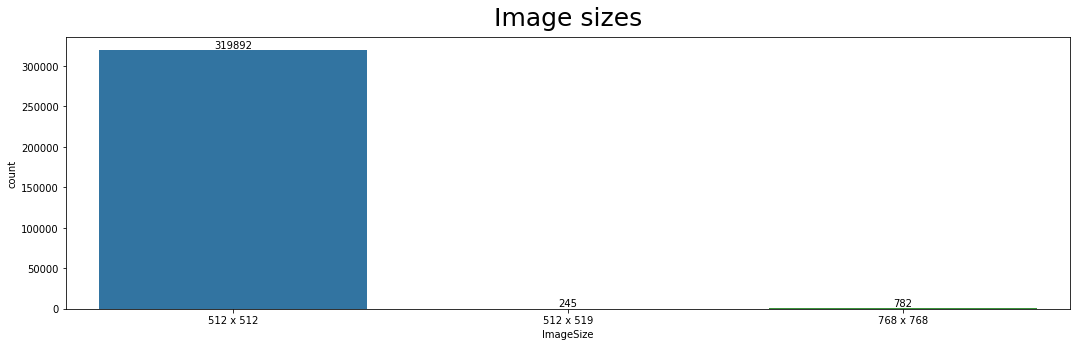

In [20]:
meta_train["ImageSize"] = meta_train["Rows"].astype(str) + " x " + meta_train["Columns"].astype(str)

plt.figure(figsize=(18, 5))
ax = sns.countplot(data=meta_train, x="ImageSize")
for container in ax.containers:
    ax.bar_label(container)
plt.title('Image sizes', fontsize=25, y=1.02)

Text(0.5, 1.02, 'Slice thickness distribution')

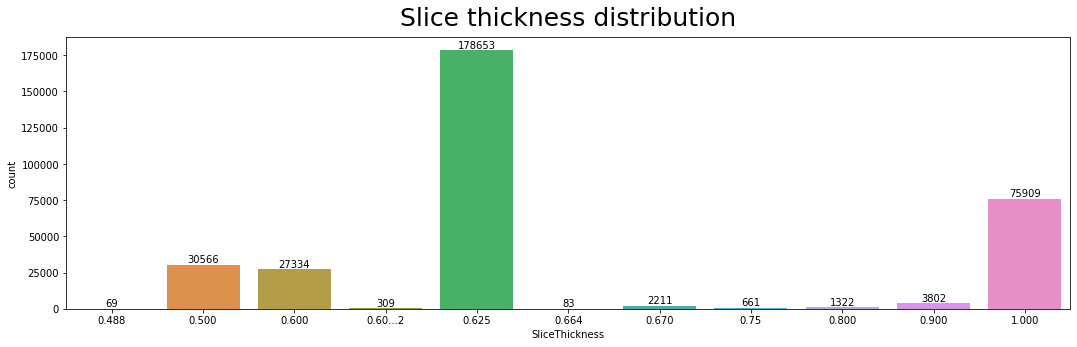

In [21]:
# Plot slice thickness
plt.figure(figsize=(18, 5))
ax = sns.countplot(data=meta_train, x="SliceThickness")
for container in ax.containers:
    ax.bar_label(container)
ax.set_xticklabels(['0.488','0.500','0.600','0.60...2','0.625','0.664','0.670','0.75','0.800','0.900','1.000'])
plt.title('Slice thickness distribution', fontsize=25, y=1.02)

Text(0.5, 0, 'Number of Slices')

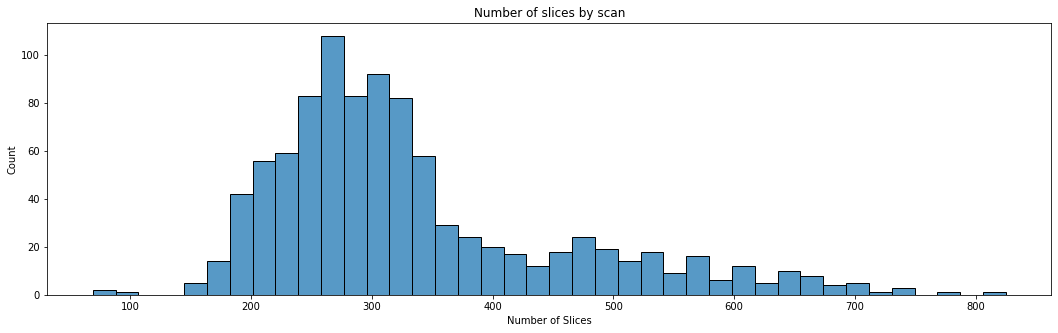

In [22]:
slice_counts = meta_train["StudyInstanceUID"].value_counts().reset_index()
slice_counts.columns = ["StudyInstanceUID", "count"]

# Distribution of slices counts
plt.figure(figsize=(18, 5))
sns.histplot(data=slice_counts, x="count", bins=40)
plt.title("Number of slices by scan")
plt.xlabel("Number of Slices")

In [23]:
meta_train['ImagePositionPatient_x'] = meta_train['ImagePositionPatient'].apply(lambda x: float(x.replace('[','').replace(']','').replace(',','').split()[0]))
meta_train['ImagePositionPatient_y'] = meta_train['ImagePositionPatient'].apply(lambda x: float(x.replace('[','').replace(']','').replace(',','').split()[1]))
meta_train['ImagePositionPatient_z'] = meta_train['ImagePositionPatient'].apply(lambda x: float(x.replace('[','').replace(']','').replace(',','').split()[2]))

In [24]:
# Clean metadata
meta_train_clean = meta_train.drop(['SOPInstanceUID','ImagePositionPatient','ImageOrientationPatient','ImageSize'], axis=1)
meta_train_clean.rename(columns={"Rows": "ImageHeight", "Columns": "ImageWidth","InstanceNumber": "Slice"}, inplace=True)
meta_train_clean = meta_train_clean[['StudyInstanceUID','Slice','ImageHeight','ImageWidth','SliceThickness','ImagePositionPatient_x','ImagePositionPatient_y','ImagePositionPatient_z']]
meta_train_clean.sort_values(by=['StudyInstanceUID','Slice'], inplace=True)
meta_train_clean.reset_index(drop=True, inplace=True)

# Export information
meta_train_clean.to_csv("meta_train_clean.csv", index=False)

# Preview first few columns
meta_train_clean.head(3)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z
0,1.2.826.0.1.3680043.10016,1,512,512,0.625,-57.808,-31.295,-25.865
1,1.2.826.0.1.3680043.10016,2,512,512,0.625,-57.808,-31.295,-26.178
2,1.2.826.0.1.3680043.10016,3,512,512,0.625,-57.808,-31.295,-26.490
